# Statistical Plan

This document is dedicated for detailed explanation of statistical analysis of M.O.R.E. (Masked Object Recognition Experiment). We will start with detailed explanation of the data itself. Overall we collected 22 different type of data where we will mention here the ones related with the analysis (for the rest please see "fulldataset.csv") .

**1) Participant Number:** Number of the participant, overall we have 30 participants. |pt_num|

**2) Trial Number:** As the name suggest corresponding trial number; for each participant whole experiment consisted of 1440 trials (excluding the training phase). |trial_nbr|

**3) Block Number:** Overall, experiment consists of 10 blocks (and 9 break in between the blocks), thus each block contained of 144 trials. |block_number|

**4) Reaction Time:** One of the key data to be analyzed, recorded reaction time given to a trial, a timer sets on after the stimulus presentation until a response with key is given. Clarification, reaction time does not include stimulus presentation only the time after stimulus presentation and until a key is pressed. maximum of 10 seconds window was allowed if no response given within this 10 seconds; next trial begins. |rt|

**5) Stimulus Onset Asynchrony (SOA):** This terms is currently a bit misleading, we mean duration of stimulus presented (time that image stayed on the screen), this changed across the experiment to be 25ms, 50ms and 100ms. Each duration type was evenly distributed (in a randomized order) through the experiment 480 trial per type. |soa|

**6) Accuracy:** Registry of whether a participant correctly chose the the category of the given stimuli. Thus, it is either TRUE or FALSE. |acc|

**7) Category:** Category of the presented object, one of the following options: bird, tree, cat, building, bus, person, fire hydrant, banana. |category|

**8) Chosen Category:** Response of the participant selecting the category of the object. |choiced_category|

**9) Difficulty:** Difficulty of the occlusion (how much of the image is being occluded), control = no occlusion, low = smaller occlusion, high = greater occlusion. |difficulty|.

**10) Size of Occlusion:** As we opted for partial viewing occlusion type, this occlusion also differs into two, having few but large blobs blocking the image, and many but small images blocking the image, |size_occl|

**11) Pressed Key:** Which key was pressed to give response to the trial? We recorded each pressed key per trial. |pressed_key|

**12) Correct Key:** This holds the value which key was supposed to be pressed in order to give the correct answer. |correct_key|





*Overall, we have had 3 different effect parameters (SOA, Difficulty and Size of Occlusion) that is hypothesized to influence the accuracy and the reaction time.*

## Processing Data

We must start with importing necessary libraries, datasets and merging everything into one big set. Where we will start with data cleaning and determination of outliers. 

In [1]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import glob
import statistics
import pingouin as pg
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import AnovaRM
import warnings
warnings.filterwarnings("ignore")

In [2]:

# use a personal style sheet
plt.style.use("./styles/mystyle.mplstyle")

# listing all the current data
data_files = glob.glob(r'../Experiment/data/*.csv') # taking only the two complete files

df = pd.DataFrame()
df = pd.concat([ pd.read_csv(file) for file in data_files ])

# select only the main task
df = df.loc[df['task']=='experiment']

# dropping unnecessary columns in terms of data analysis
df = df.drop(labels = ["Age", "Gender", "Handedness", "manipulation", "mask", "type_occl",
                       "mask_filename", "task", "Experiment Duration", "Version"], axis=1)
df = df.reset_index(drop = True)

# extracting sample size
n = len(set(df.pt_num))
print(n)
# 
df.head()
#Overall trial number
len(df.index) #43200

30


43200

### Managing Missing Datapoints and Outlier Determination

Now as we have our merged dataset available to us (df) we now should start with close inspection of the datasets, this including managing missing datapoints. Coding of the experiment allow us to easily find such occasion, we will be looking for a reaction time higher-equal to 10 and pressed key is to be "NAN". we will remove such rows from the dataset.



In [3]:
nan = df[df["pressed_key"] == "NAN"].index
# there is only one occasion where there is NAN,  participant-19, trial number 1122
# magic number remove this 

In [4]:
df = df.drop(nan, axis = 0) #remove it via lable that makes sense

In [5]:
df[df["pressed_key"] == "NAN"]
# Now it is removed

,pt_num,trial_nbr,block_number,rt,soa,acc,category,choiced_category,difficulty,size_occl,filename,pressed_key,correct_key


**For outliers**: 99th percentile cut-off value will be employed when it comes to reaction time. Also for the accuracy we will check if any participant is close to (or even below) of a chance level which is 12.5% given that there are 8 possible options to be chosen. These outliers will be removed from the dataset. Let us start with averages of each participant.

## Inspecting plots for Outliers

Overall Average of Accuracy 0.8608301118081437
Overall Average of Reaction Time 0.9536470651404071


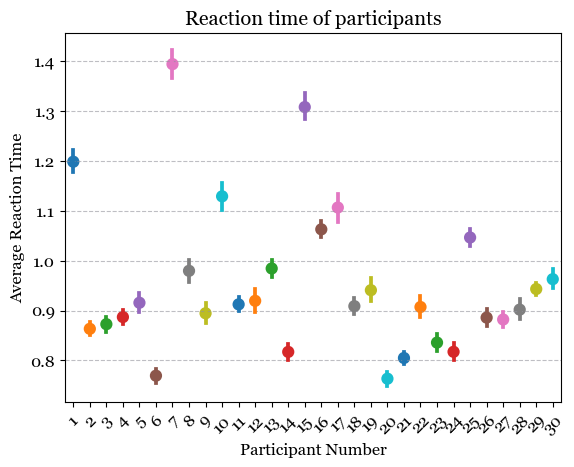

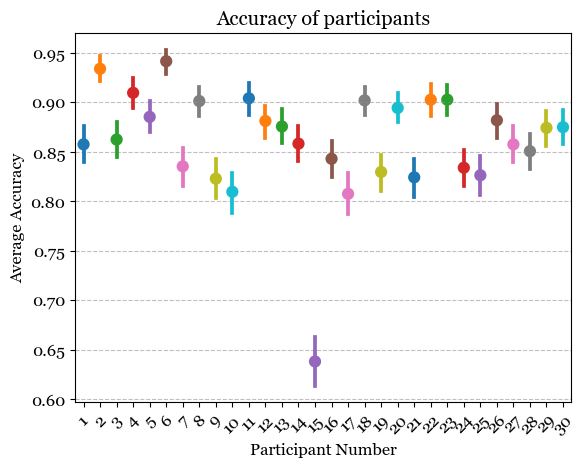

In [6]:
plt.figure()
plot = sns.pointplot(
data = df,
y = 'rt',
x = 'pt_num',
#order = ['cat', 'bird', 'firehydrant','person', 'banana','bus','building', 'tree'],
# hue = 'soa',
# hue = 'size_occl',
palette = 'tab10',
)
plt.xticks(rotation= 45)
plt.title("Reaction time of participants")
plt.ylabel("Average Reaction Time")
plt.xlabel("Participant Number")

plt.figure()
plot = sns.pointplot(
data = df,
y = 'acc',
x = 'pt_num',
#order = ['cat', 'bird', 'firehydrant','person', 'banana','bus','building', 'tree'],
# hue = 'soa',
# hue = 'size_occl',
palette = 'tab10',
)
plt.xticks(rotation= 45)
plt.ylabel("Average Accuracy")
plt.xlabel("Participant Number")
plt.title("Accuracy of participants")

print("Overall Average of Accuracy " +str(statistics.mean(df["acc"])))
print("Overall Average of Reaction Time " +str(statistics.mean(df["rt"])))

<Axes: xlabel='rt', ylabel='Count'>

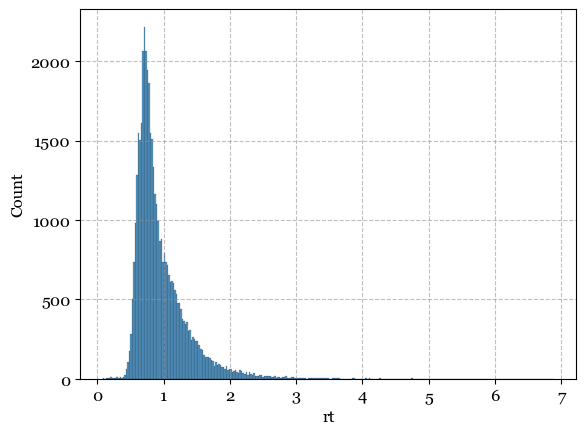

In [7]:
sns.histplot(df['rt'])

**Reaction time plot** shows very heterogeneous distribution. Outliers will be identified using 99th percentile and removed.
 
**Accuracy plot** shows rather stable accuracy levels across participants except participant-15 where participants score 65% correct while the average is 86%. For that reason participant 15 will be removed from further analysis as being an outlier participant.

43199
41759


Text(0.5, 1.0, 'Accuracy of participants')

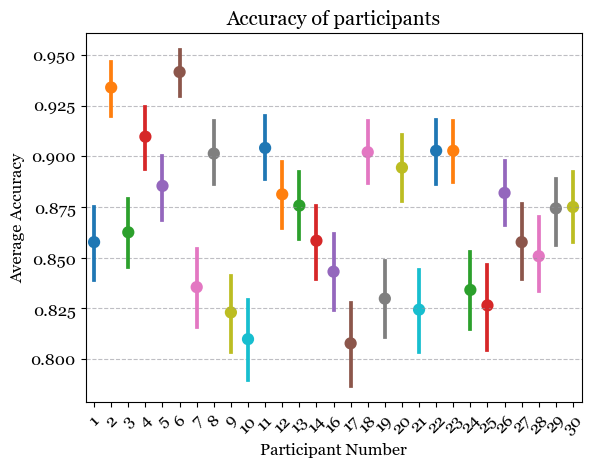

In [8]:
outlier_pt = df[(df["pt_num"] == 15)].index
print(len(df))
df.drop(outlier_pt, inplace = True)
print(len(df))

plt.figure()
plot = sns.pointplot(
data = df,
y = 'acc',
x = 'pt_num',
#order = ['cat', 'bird', 'firehydrant','person', 'banana','bus','building', 'tree'],
# hue = 'soa',
# hue = 'size_occl',
palette = 'tab10',
)
plt.xticks(rotation= 45)
plt.ylabel("Average Accuracy")
plt.xlabel("Participant Number")
plt.title("Accuracy of participants")

**Now as we have removed the participant-15, our next step is to remove the outliers from the reaction time, for that we will be calculating the 99th percentile and we will remove values bigger than 99th percentile. Throughout the notebook, we show how many data points are being dropped due to our outlier decisisions (look for len(df)).

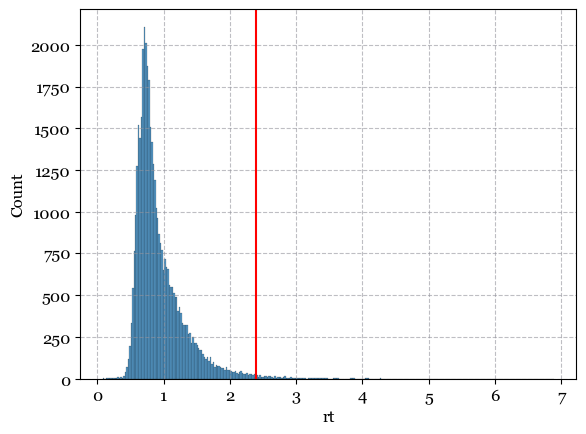

In [9]:
sns.histplot(df["rt"])
ninty_ninth = df["rt"].quantile(0.99)
plt.axvline(ninty_ninth, color="red")

In [10]:
df_to_dropped = df[(df["rt"] > ninty_ninth)].index

41759
418
41341


<Axes: xlabel='rt', ylabel='Count'>

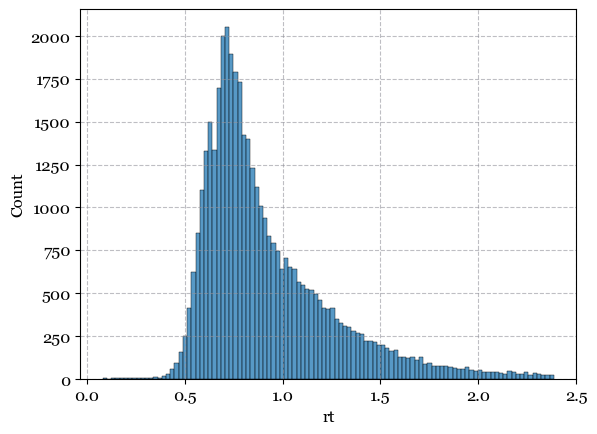

In [11]:
print(len(df))
print(len(df_to_dropped))
df.drop(df_to_dropped, inplace = True)
print(len(df))

sns.histplot(df["rt"])

We also need to remove unlikely small reaction time values, due to nature of the experiment reaction time below 300ms is very unlikely since it is during still presentation of the mask without response set being presented. For that reason we will use quantile value that is approximate to 300ms which is shown below to be 0.001 percentile values below that cut-off will be removed from the data as well.

41341
42
41299


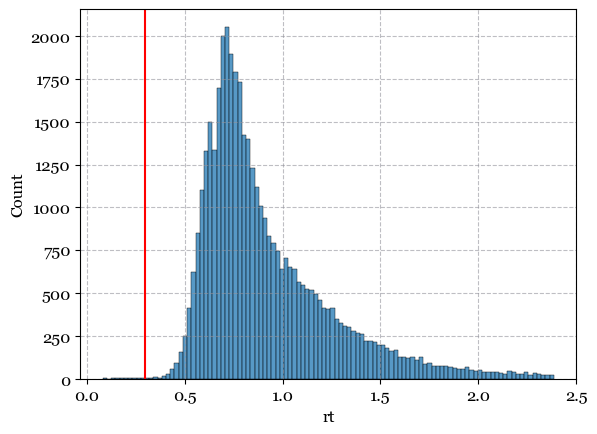

In [12]:
sns.histplot(df["rt"])
zero_point_first_quantile = df["rt"].quantile(0.001)
plt.axvline(zero_point_first_quantile, color="red")

df_to_dropped = df[(df["rt"] < zero_point_first_quantile)].index

print(len(df))
print(len(df_to_dropped))
df.drop(df_to_dropped, inplace = True)
print(len(df))

<Axes: xlabel='rt', ylabel='Count'>

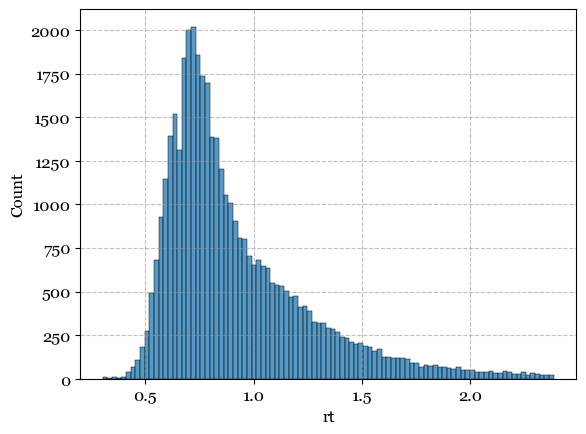

In [13]:
sns.histplot(df["rt"])

**We have removed 418 datapoints that were higher than 99th quantile. This step concludes the pre-processing stage of data, initially we have had 43200 trials after preprocessing (exclusion of one participant and reaction times higher than 99th quantile and 0.001 quantile) we are left with 41299. Overall we have rejected 1901 trials. Now we will continue with ANOVA tests and their corresponding assumption checks.**

Also, let us now export the current dataset to csv file to avoid repeating the same cleaning process in other scripts.


In [14]:
df.to_csv("DF_cleaned.csv")

## Anova Testing (RT)

### Main Anova size of occlusion x SOA
We only take the true values of accuracy for reaction time anova testing. We also do multiple comparison and do posthoc.

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,size_occl,0.017595,1,28,0.017595,20.822648,0.000091,0.000091,0.007502,1.000000
1,soa,0.009339,2,56,0.004669,7.388909,0.001420,0.002688,0.003996,0.843989
2,size_occl * soa,0.000221,2,56,0.000111,0.239041,0.788182,0.749200,0.000095,0.838085


,0.100,0.050,0.025
0.100,1.000000,0.000022,0.013219
0.050,0.000022,1.000000,0.370207
0.025,0.013219,0.370207,1.000000


,few large,many small
few large,1.000000e+00,3.606678e-08
many small,3.606678e-08,1.000000e+00


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1aea4bba520>)

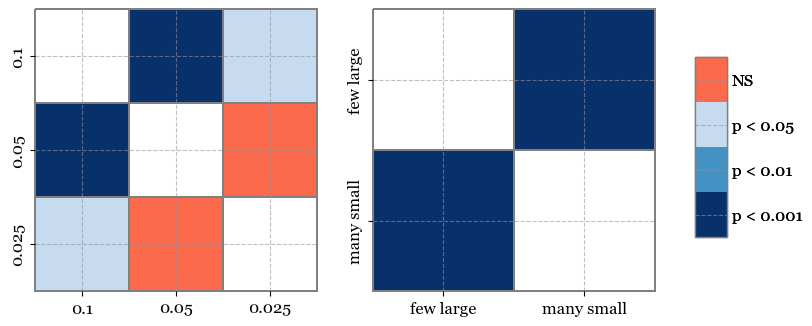

In [15]:
# Main Anova
df_correct =  df[df['acc'] == True]

# Perform Two-Way ANOVA
main_result = pg.rm_anova(data=df_correct, dv='rt', within=['size_occl', 'soa'], subject= 'pt_num', detailed=True)
display(main_result)

#multiple comparisons
posthoc_soa = sp.posthoc_ttest(df_correct, val_col= "rt", group_col= "soa", p_adjust='bonferroni')
display(posthoc_soa)

posthoc_size_occl = sp.posthoc_ttest(df_correct, val_col= "rt", group_col= "size_occl", p_adjust='bonferroni')
display(posthoc_size_occl)

#PLotting them as signplots
fig, ax = plt.subplots(1,2,figsize=(8, 6))
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax =ax[0])

sp.sign_plot(posthoc_size_occl, **heatmap_args, ax= ax[1])

#Down below we do Tukey multiple comparisons

### Assumption Checks for Main Anova
Since it is repeated measures of Anova, we have three assumptions to meet:

1. Independence: Each of the observations should be independent.

2. Normality: The distribution of the response variable is normally distributed.

3. Sphericity: The variances of the differences between all combinations of related groups must be equal.

Tests
1. Due to nature of experimental design we have no reason to suspect assumption of independence to be violated.
2. We will check normality with histograms and shapiro-wilk test.
3. For Sphericity please see "Detailed Sphericity Check.R" file.

,W,pval,normal
0,0.8868,0.004801,False


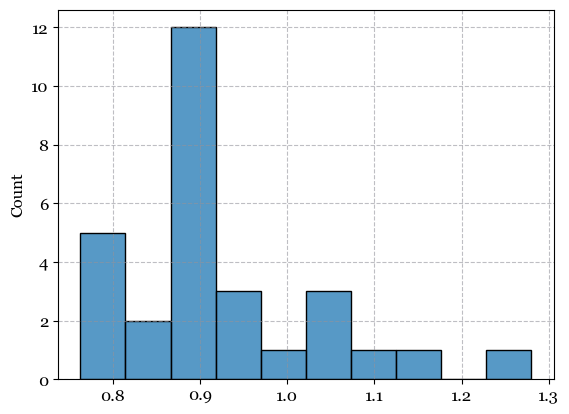

In [16]:
# Doing participant based Normality check
rt_pt_list = []
for i in range(30):
    df_temp = df[(df['pt_num'] == (i+1))]
    rt_pt_list.append((np.mean(df_temp['rt'])))
    
sns.histplot(rt_pt_list)
pg.normality(rt_pt_list)

**Normality:** Normality Assumption is violated, therefore we will conduct the same test with rank-transformed Anova as well to re-validate our results.

**Sphericity:** As the R script shows, Mauchly test shows no significant result on violation of sphericity assumptions. We can conclude that sphericity assumption is met.

### Sub-Anova on many small checking for effects of difficulty X Soa

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,difficulty,0.382962,2,56,0.191481,69.298306,7.136366e-16,1.428378e-13,0.090164,0.830728
1,soa,0.013710,2,56,0.006855,3.573610,3.462151e-02,4.776422e-02,0.003535,0.769250
2,difficulty * soa,0.014817,4,112,0.003704,2.343339,5.910163e-02,8.829592e-02,0.003820,0.652795


,control,low,high
control,1.000000e+00,2.163631e-21,6.961069e-45
low,2.163631e-21,1.000000e+00,2.453616e-06
high,6.961069e-45,2.453616e-06,1.000000e+00


,0.100,0.050,0.025
0.100,1.000000,0.000986,0.105172
0.050,0.000986,1.000000,0.507985
0.025,0.105172,0.507985,1.000000


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1aea6ae2880>)

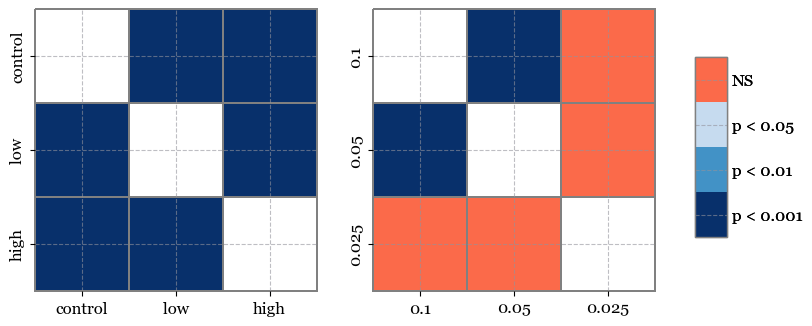

In [17]:
#Occluder size many small
df_many_small = df[(df['size_occl'] == "many small") & df['acc'] == True ]

many_small_anova = pg.rm_anova(data= df_many_small, dv='rt', within=["difficulty", 'soa'], subject = "pt_num", detailed = True)
display(many_small_anova)

posthoc_soa = sp.posthoc_ttest(df_many_small, val_col= "rt", group_col= "difficulty", p_adjust='bonferroni')
display(posthoc_soa)

posthoc_size_occl = sp.posthoc_ttest(df_many_small, val_col= "rt", group_col= "soa", p_adjust='bonferroni')
display(posthoc_size_occl)

#PLotting them as signplots
fig, ax = plt.subplots(1,2,figsize=(8, 6))
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax =ax[0])

sp.sign_plot(posthoc_size_occl, **heatmap_args, ax= ax[1])

#Down below we do Tukey multiple comparisons

### Assumption Checks for sub-Anova (RT_many_small)
Since it is repeated measures of Anova, we have three assumptions to meet:

1. Independence: Each of the observations should be independent.

2. Normality: The distribution of the response variable is normally distributed.

3. Sphericity: The variances of the differences between all combinations of related groups must be equal.

Tests
1. Due to nature of experimental design we have no reason to suspect assumption of independence to be violated.
2. We will check normality with histograms and shapiro-wilk test.
3. For Sphericity please see "Detailed Sphericity Check.R" file.

,W,pval,normal
0,0.884164,0.004178,False


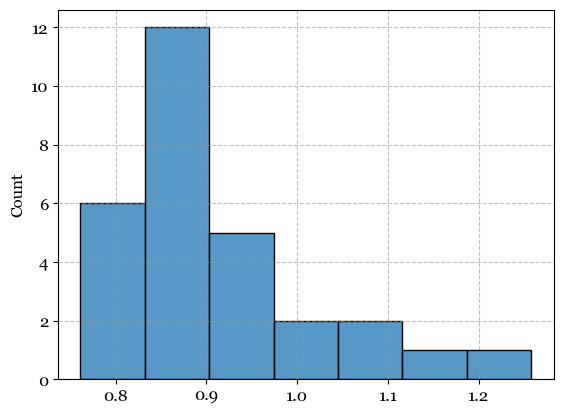

In [18]:
# Doing participant based Normality check
rt_pt_list = []
for i in range(30):
    df_temp = df_many_small[(df_many_small['pt_num'] == (i+1))]
    rt_pt_list.append((np.mean(df_temp['rt'])))
    
sns.histplot(rt_pt_list)
pg.normality(rt_pt_list)

**Normality:** Normality Assumption is violated, therefore we will conduct the same test with rank-transformed Anova as well to re-validate our results.

**Sphericity:** As the R script shows, Mauchly test shows violation of sphericity assumptions. Although after GGe correction, corresponding values for effects are still significant.

### Sub-Anova on few large checking for effects of difficulty X Soa

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,difficulty,0.104859,2,56,0.052429,38.700686,2.784688e-11,6.016698e-10,0.027640,0.853119
1,soa,0.009745,2,56,0.004873,3.438251,3.904722e-02,4.065999e-02,0.002635,0.968883
2,difficulty * soa,0.007706,4,112,0.001926,1.972064,1.036076e-01,1.255251e-01,0.002085,0.737476


,high,low,control
high,1.000000e+00,0.000002,1.040531e-14
low,2.025458e-06,1.000000,7.387535e-03
control,1.040531e-14,0.007388,1.000000e+00


,0.100,0.050,0.025
0.100,1.000000,0.019349,0.21499
0.050,0.019349,1.000000,1.00000
0.025,0.214990,1.000000,1.00000


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1aea7102ca0>)

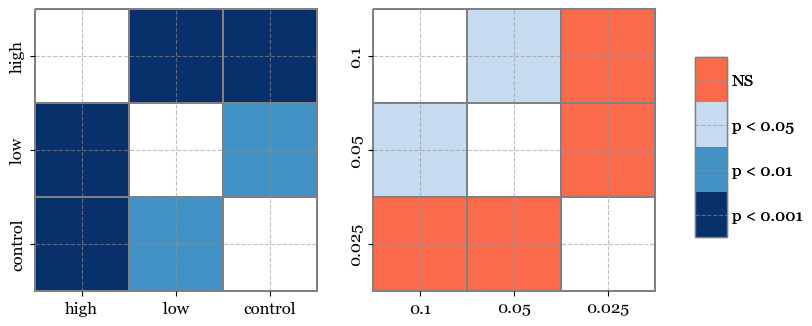

In [19]:
#Occluder size few large
df_few_large = df[(df['size_occl'] == "few large") & df['acc'] == True ]

many_small_anova = pg.rm_anova(data= df_few_large, dv='rt', within=["difficulty", 'soa'], subject = "pt_num", detailed = True)
display(many_small_anova)

posthoc_soa = sp.posthoc_ttest(df_few_large, val_col= "rt", group_col= "difficulty", p_adjust='bonferroni')
display(posthoc_soa)

posthoc_size_occl = sp.posthoc_ttest(df_few_large, val_col= "rt", group_col= "soa", p_adjust='bonferroni')
display(posthoc_size_occl)

#PLotting them as signplots
fig, ax = plt.subplots(1,2,figsize=(8, 6))
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax =ax[0])

sp.sign_plot(posthoc_size_occl, **heatmap_args, ax= ax[1])

#Down below we do Tukey multiple comparisons

### Assumption Checks for Sub-Anova (RT_Few_large)
Since it is repeated measures of Anova, we have three assumptions to meet:

1. Independence: Each of the observations should be independent.

2. Normality: The distribution of the response variable is normally distributed.

3. Sphericity: The variances of the differences between all combinations of related groups must be equal.

Tests
1. Due to nature of experimental design we have no reason to suspect assumption of independence to be violated.
2. We will check normality with histograms and shapiro-wilk test.
3. For Sphericity please see "Detailed Sphericity Check.R" file.

,W,pval,normal
0,0.884115,0.004167,False


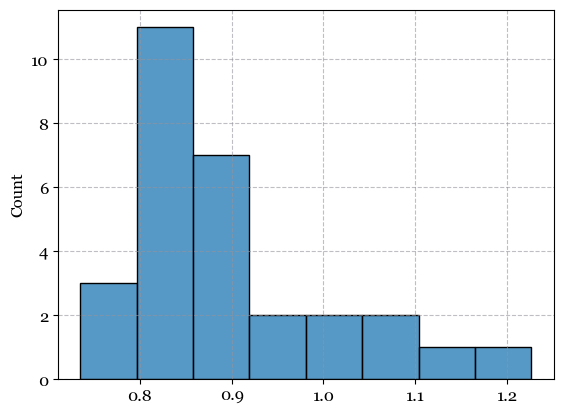

In [20]:
# Doing participant based Normality check
rt_pt_list = []
for i in range(30):
    df_temp = df_few_large[(df_few_large['pt_num'] == (i+1))]
    rt_pt_list.append((np.mean(df_temp['rt'])))
    
sns.histplot(rt_pt_list)
pg.normality(rt_pt_list)

**Normality:** Normality Assumption is violated, therefore we will conduct the same test with rank-transformed Anova as well to re-validate our results.

**Sphericity:** As the R script shows, Mauchly test shows no violation of sphericity assumptions.

# Accuracy

### Main Anova size_occl X soa

In [21]:
df_acc = df
totalT = df_acc.groupby(['pt_num', 'size_occl', 'soa'], as_index=False)['acc'].count()
correctT = df_acc.groupby(['pt_num', 'size_occl', 'soa'], as_index=False)['acc'].sum()
totalT['acc'] = ((correctT['acc']/totalT['acc'].round(3)))*100

df_acc = pd.DataFrame(totalT)
xx = pg.rm_anova(data= df_acc, dv='acc', within=["size_occl", 'soa'], subject = "pt_num", detailed = True)
display(xx)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,size_occl,4312.751074,1,28,4312.751074,224.239314,6.808913e-15,6.808913e-15,0.595240,1.000000
1,soa,1357.412994,2,56,678.706497,149.228451,3.643246e-23,1.224424e-21,0.316408,0.926650
2,size_occl * soa,243.282976,2,56,121.641488,35.985105,8.916943e-11,3.903258e-10,0.076602,0.925336


,0.025,0.050,0.100
0.025,1.000000e+00,0.016847,7.571858e-07
0.050,1.684657e-02,1.000000,1.824251e-02
0.100,7.571858e-07,0.018243,1.000000e+00


,few large,many small
few large,1.000000e+00,9.297042e-27
many small,9.297042e-27,1.000000e+00


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1aea75a9a00>)

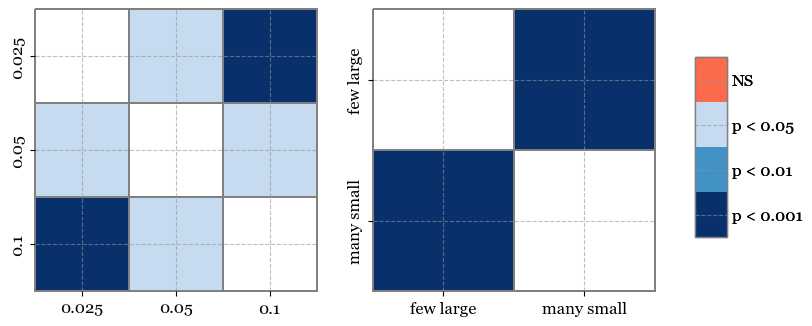

In [22]:
posthoc_soa = sp.posthoc_ttest(df_acc, val_col= "acc", group_col= "soa", p_adjust='bonferroni')
display(posthoc_soa)

posthoc_size_occl = sp.posthoc_ttest(df_acc, val_col= "acc", group_col= "size_occl", p_adjust='bonferroni')
display(posthoc_size_occl)

#PLotting them as signplots
fig, ax = plt.subplots(1,2,figsize=(8, 6))
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax =ax[0])

sp.sign_plot(posthoc_size_occl, **heatmap_args, ax= ax[1])

#Down below we do Tukey multiple comparisons

### Assumption Checks for Main Anova (ACC)
Since it is repeated measures of Anova, we have three assumptions to meet:

1. Independence: Each of the observations should be independent.

2. Normality: The distribution of the response variable is normally distributed.

3. Sphericity: The variances of the differences between all combinations of related groups must be equal.

Tests
1. Due to nature of experimental design we have no reason to suspect assumption of independence to be violated.
2. We will check normality with histograms and shapiro-wilk test.
3. For Sphericity please see "Detailed Sphericity Check.R" file.

,W,pval,normal
0,0.966193,0.461623,True


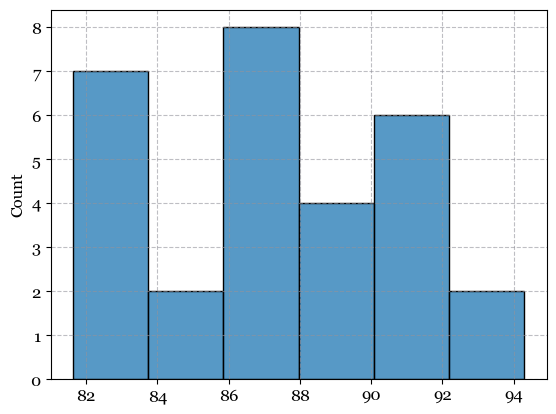

In [23]:
# Doing participant based Normality check
rt_pt_list = []
for i in range(30):
    df_temp = df_acc[(df_acc['pt_num'] == (i+1))]
    rt_pt_list.append((np.mean(df_temp['acc'])))
    
sns.histplot(rt_pt_list)
pg.normality(rt_pt_list)

**Normality:** Normality Assumption holds.

**Sphericity:** As the R script shows, Mauchly test shows no violation of sphericity assumptions.

### Sub Anova soa X difficulty on many_small occlusion

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,difficulty,34326.045483,2,56,17163.022742,281.539183,6.030970e-30,7.587033e-21,0.752503,0.670115
1,soa,4188.349282,2,56,2094.174641,141.185323,1.337426e-22,2.112912e-22,0.270598,0.990189
2,difficulty * soa,1606.069986,4,112,401.517496,42.241070,1.485207e-21,3.685557e-09,0.124542,0.358394


,control,high,low
control,1.000000e+00,3.224941e-54,9.444031e-28
high,3.224941e-54,1.000000e+00,1.884489e-19
low,9.444031e-28,1.884489e-19,1.000000e+00


,0.025,0.050,0.100
0.025,1.000000,0.044566,0.000015
0.050,0.044566,1.000000,0.059172
0.100,0.000015,0.059172,1.000000


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1aea7bff1c0>)

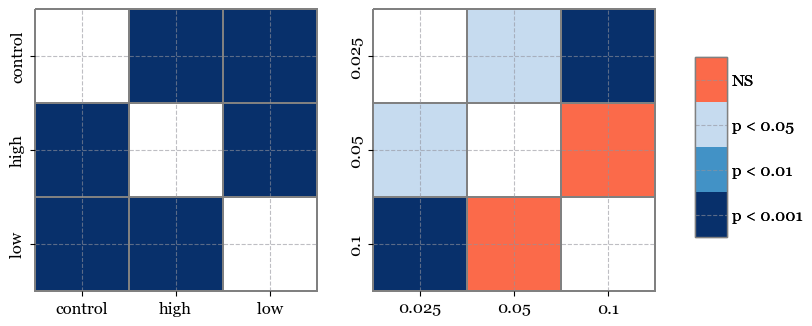

In [24]:
df_many_small_acc = df[(df['size_occl'] == "many small")]
totalT = df_many_small_acc.groupby(['pt_num', 'difficulty', 'soa', ], as_index=False)['acc'].count()
correctT = df_many_small_acc.groupby(['pt_num', 'difficulty', 'soa'], as_index=False)['acc'].sum()
totalT['acc'] = ((correctT['acc']/totalT['acc'].round(3)))*100

df_many_small_acc1 = pd.DataFrame(totalT)
xx = pg.rm_anova(data= df_many_small_acc1, dv='acc', within=["difficulty", 'soa'], subject = "pt_num", detailed = True)
display(xx)

posthoc_soa = sp.posthoc_ttest(df_many_small_acc1, val_col= "acc", group_col= "difficulty", p_adjust='bonferroni')
display(posthoc_soa)

posthoc_size_occl = sp.posthoc_ttest(df_many_small_acc1, val_col= "acc", group_col= "soa", p_adjust='bonferroni')
display(posthoc_size_occl)

#PLotting them as signplots
fig, ax = plt.subplots(1,2,figsize=(8, 6))
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax =ax[0])

sp.sign_plot(posthoc_size_occl, **heatmap_args, ax= ax[1])

#Down below we do Tukey multiple comparisons

### Assumption Checks for Sub-Anova (Many_Small)
Since it is repeated measures of Anova, we have three assumptions to meet:

1. Independence: Each of the observations should be independent.

2. Normality: The distribution of the response variable is normally distributed.

3. Sphericity: The variances of the differences between all combinations of related groups must be equal.

Tests
1. Due to nature of experimental design we have no reason to suspect assumption of independence to be violated.
2. We will check normality with histograms and shapiro-wilk test.
3. For Sphericity please see "Detailed Sphericity Check.R" file.

,W,pval,normal
0,0.961041,0.348638,True


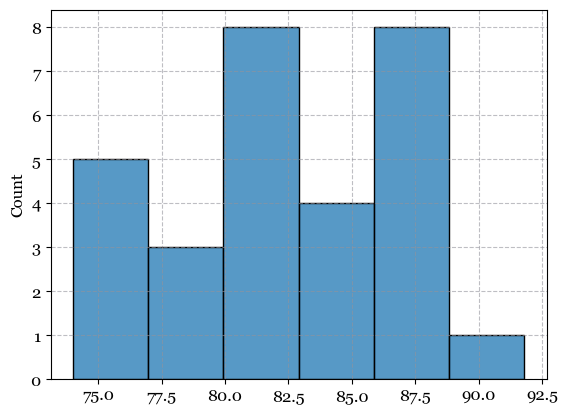

In [25]:
# Doing participant based Normality check
rt_pt_list = []
for i in range(30):
    df_temp = df_many_small_acc1[(df_many_small_acc1['pt_num'] == (i+1))]
    rt_pt_list.append((np.mean(df_temp['acc'])))
    
sns.histplot(rt_pt_list)
pg.normality(rt_pt_list)

**Normality:** Normality Assumption holds.

**Sphericity:** As the R script shows, Mauchly test shows violation of sphericity assumptions. Although after GGe correction, corresponding values for effects are still significant.

### Sub Anova soa X difficulty on few_large occlusion

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,difficulty,3422.788051,2,56,1711.394026,90.069414,3.166485e-18,1.480640e-13,0.462902,0.706891
1,soa,689.065806,2,56,344.532903,37.639180,4.363719e-11,1.768749e-10,0.147853,0.931630
2,difficulty * soa,490.121899,4,112,122.530475,14.990950,7.657116e-10,6.830495e-06,0.109855,0.493835


,control,high,low
control,1.000000e+00,2.548877e-24,1.807965e-09
high,2.548877e-24,1.000000e+00,1.001848e-10
low,1.807965e-09,1.001848e-10,1.000000e+00


,0.025,0.050,0.100
0.025,1.000000,0.075995,0.000024
0.050,0.075995,1.000000,0.025313
0.100,0.000024,0.025313,1.000000


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1aea824c1c0>)

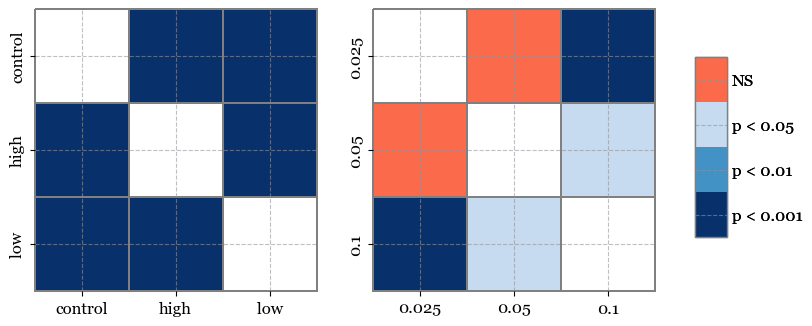

In [26]:
df_few_large_acc = df[(df['size_occl'] == "few large")]
totalT = df_few_large_acc.groupby(['pt_num', 'difficulty', 'soa', ], as_index=False)['acc'].count()
correctT = df_few_large_acc.groupby(['pt_num', 'difficulty', 'soa'], as_index=False)['acc'].sum()
totalT['acc'] = ((correctT['acc']/totalT['acc'].round(3)))*100

df_few_large_acc1 = pd.DataFrame(totalT)
xx = pg.rm_anova(data= df_few_large_acc1, dv='acc', within=["difficulty", 'soa'], subject = "pt_num", detailed = True)
display(xx)

posthoc_soa = sp.posthoc_ttest(df_few_large_acc1, val_col= "acc", group_col= "difficulty", p_adjust='bonferroni')
display(posthoc_soa)

posthoc_size_occl = sp.posthoc_ttest(df_few_large_acc1, val_col= "acc", group_col= "soa", p_adjust='bonferroni')
display(posthoc_size_occl)

#PLotting them as signplots
fig, ax = plt.subplots(1,2,figsize=(8, 6))
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax =ax[0])

sp.sign_plot(posthoc_size_occl, **heatmap_args, ax= ax[1])

#Down below we do Tukey multiple comparisons


### Assumption Checks for Sub-Anova (Few_Large)
Since it is repeated measures of Anova, we have three assumptions to meet:

1. Independence: Each of the observations should be independent.

2. Normality: The distribution of the response variable is normally distributed.

3. Sphericity: The variances of the differences between all combinations of related groups must be equal.

Tests
1. Due to nature of experimental design we have no reason to suspect assumption of independence to be violated.
2. We will check normality with histograms and shapiro-wilk test.
3. For Sphericity please see "Detailed Sphericity Check.R" file.

,W,pval,normal
0,0.974193,0.67753,True


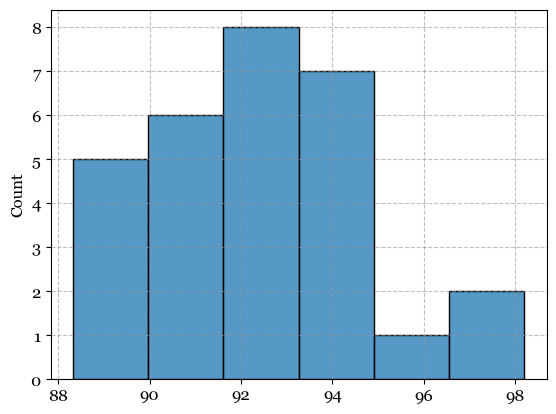

In [27]:
# Doing participant based Normality check
rt_pt_list = []
for i in range(30):
    df_temp = df_few_large_acc1[(df_few_large_acc1['pt_num'] == (i+1))]
    rt_pt_list.append((np.mean(df_temp['acc'])))
    
sns.histplot(rt_pt_list)
pg.normality(rt_pt_list)

**Normality:** Normality Assumption holds.

**Sphericity:** As the R script shows, Mauchly test shows violation of sphericity assumptions. Although after GGe correction, corresponding values for effects are still significant.

## Conclusion

In conclusion, normality assumption for Reaction time analysis are violated, for that reason we will analyze this data again as rank-transformed ANOVA.

Also, violation of sphericity assumption does not necessarily influence the results since even after GGe correction all of the shown effects were still shown as significant.

Next, please see the "Rank-transformed_RT.ipynb" for the rank-transformed ANOVA to see the results.